In [1]:
import numpy as np
import pywt
from scipy.io import loadmat


# Load and normalize the hyperspectral cube
file_path = '5e128x128SphericGFDefaultSNR80.mat'
data = loadmat(file_path)
synthetic_image = data['syntheticImageNoisy']
end=data['endmembersGT']
synthetic_image = synthetic_image / np.max(synthetic_image)


# Reshape the data so that each pixel's spectral data is a 1D vector
vector_data = end


# Perform wavelet transform on the first vector to get the coefficient sizes
sample_vector = vector_data[0]
cA, cD = pywt.dwt(sample_vector, 'bior1.3')  # Use the desired wavelet type


# Initialize cubes based on actual sizes of cA and cD
approximation = np.empty((vector_data.shape[0], cA.shape[0]))
detail = np.empty((vector_data.shape[0], cD.shape[0]))


# Apply wavelet transform to each 1D spectral vector and store coefficients in the cubes
for idx, vector in enumerate(vector_data):
    cA, cD = pywt.dwt(vector, 'bior1.3')  # Perform wavelet transform
    approximation[idx, :] = cA
    detail[idx, :] = cD


# Reshape the coefficient cubes back to spatial dimensions
#approximation_cube = approximation_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)
#detail_cube = detail_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)


# Output the shapes to verify
print("Shape of original cube:", end.shape)
print("Shape of approximation cube:", approximation.shape)
print("Shape of detail cube:", detail.shape)



Shape of original cube: (5, 431)
Shape of approximation cube: (5, 218)
Shape of detail cube: (5, 218)


In [2]:
import numpy as np
import pywt
from scipy.io import loadmat


# Load and normalize the hyperspectral cube
file_path = '5e128x128SphericGFDefaultSNR80.mat'
data = loadmat(file_path)
synthetic_image = data['syntheticImageNoisy']
synthetic_image = synthetic_image / np.max(synthetic_image)


# Reshape the data so that each pixel's spectral data is a 1D vector
vector_data = synthetic_image.reshape(-1, synthetic_image.shape[2])  # Shape: (128*128, 431)


# Perform wavelet transform on the first vector to get the coefficient sizes
sample_vector = vector_data[0]
cA, cD = pywt.dwt(sample_vector, 'bior1.3')  # Use the desired wavelet type


# Initialize cubes based on actual sizes of cA and cD
approximation_cube = np.empty((vector_data.shape[0], cA.shape[0]))
detail_cube = np.empty((vector_data.shape[0], cD.shape[0]))


# Apply wavelet transform to each 1D spectral vector and store coefficients in the cubes
for idx, vector in enumerate(vector_data):
    cA, cD = pywt.dwt(vector, 'bior1.3')  # Perform wavelet transform
    approximation_cube[idx, :] = cA
    detail_cube[idx, :] = cD


# Reshape the coefficient cubes back to spatial dimensions
approximation_cube = approximation_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)
detail_cube = detail_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)


# Output the shapes to verify
print("Shape of original cube:", synthetic_image.shape)
print("Shape of approximation cube:", approximation_cube.shape)
print("Shape of detail cube:", detail_cube.shape)




Shape of original cube: (128, 128, 431)
Shape of approximation cube: (128, 128, 218)
Shape of detail cube: (128, 128, 218)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt


hyperspectral_data = approximation_cube
endmembers_gt = approximation

print(endmembers_gt.shape)
print(hyperspectral_data.shape)


(5, 218)
(128, 128, 218)


In [4]:
# Reshape the data for the neural network
height, width, bands = hyperspectral_data.shape
data_for_nn = hyperspectral_data.reshape((height * width, bands))


In [5]:

# Convert to PyTorch tensors
data_tensor = torch.Tensor(data_for_nn)

print(data_tensor.shape)
endmembers_gt_tensor = torch.Tensor(endmembers_gt)

print(endmembers_gt_tensor.shape)



torch.Size([16384, 218])
torch.Size([5, 218])


In [6]:
# Assuming data_tensor has more samples than endmembers_gt_tensor
num_samples_to_keep = endmembers_gt_tensor.size(0)
#print('num_samples_to_keep',num_samples_to_keep)



In [7]:
# Adjust the size of data_tensor
data_tensor = data_tensor[:num_samples_to_keep]
print(data_tensor.shape)


torch.Size([5, 218])


In [8]:

# Combine data and ground truth endmembers into a single dataset
nn_dataset = TensorDataset(data_tensor, endmembers_gt_tensor)



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom activation function
def custom_bior_activation(x):
    return F.relu(x) * torch.sin(5 * x) * torch.exp(-0.5 * torch.square(x))


# Define the CNN-based neural network model
class CNNEndmemberPredictionNet(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNNEndmemberPredictionNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)  # Added layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * (bands // 8), 256)
        self.fc2 = nn.Linear(256, output_size)

    def forward(self, x):
        x = custom_bior_activation(self.conv1(x))  # Replacing ReLU with custom activation
        x = self.pool(x)
        x = custom_bior_activation(self.conv2(x))  # Replacing ReLU with custom activation
        x = self.pool(x)
        x = custom_bior_activation(self.conv3(x))  # Replacing ReLU with custom activation
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = custom_bior_activation(self.fc1(x))  # Replacing ReLU with custom activation
        x = self.fc2(x)
        return x


In [10]:
# Instantiate the CNN model with a specified input_channels and output_size
input_channels = bands  # Assuming each band as a channel
print(input_channels)
cnn_model = CNNEndmemberPredictionNet(input_channels, endmembers_gt.shape[1])

# Define loss function and optimizer
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Convert the data to a DataLoader
nn_loader = DataLoader(nn_dataset, batch_size=40, shuffle=True)



218


In [14]:

# Training loop
num_epochs = 1500 # Reduced the number of epochs
for epoch in range(num_epochs):
    for inputs, targets in nn_loader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)

        # Mean Squared Error (MSE) Loss
        loss_mse = criterion_mse(outputs, targets)

        # Spectral Angle Mapper (SAM) Loss
        normalized_outputs = F.normalize(outputs, p=2, dim=1)
        normalized_targets = F.normalize(targets, p=2, dim=1)
        cos_similarity = F.cosine_similarity(normalized_outputs, normalized_targets, dim=1)
        loss_sam = 1 - cos_similarity.mean()

        # Spectral Information Divergence (SID) Loss
        epsilon = 1e-8
        loss_sid = torch.sum(targets * torch.log((targets + epsilon) / (outputs + epsilon)))
        
        # Spectral Angle Divergence (SAD) Loss
        sin_similarity = torch.sqrt(1 - cos_similarity**2)
        loss_sad = sin_similarity.mean()

        # Root Mean Squared Error (RMSE) Loss
        loss_rmse = torch.sqrt(loss_mse)

        # Display losses
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch Loss - MSE: {loss_mse.item():.12f}, SAM: {loss_sam.item():.12f}, SID: {loss_sid.item():.12f}, SAD: {loss_sad.item():.12f}, RMSE: {loss_rmse.item():.12f}")

        loss_mse.backward()
        optimizer.step()

# Evaluate the model on the entire dataset
with torch.no_grad():
    predictions = cnn_model(data_tensor.unsqueeze(1))  # Add a channel dimension

Epoch 1/1500, Batch Loss - MSE: 0.001788866241, SAM: 0.008474171162, SID: 25.498239517212, SAD: 0.073145024478, RMSE: 0.042294990271
Epoch 2/1500, Batch Loss - MSE: 0.000586538750, SAM: 0.001570999622, SID: -10.786270141602, SAD: 0.036164205521, RMSE: 0.024218561128
Epoch 3/1500, Batch Loss - MSE: 0.000078835750, SAM: 0.000104546547, SID: 0.784175217152, SAD: 0.010994730517, RMSE: 0.008878950030
Epoch 4/1500, Batch Loss - MSE: 0.000413557835, SAM: 0.000951886177, SID: 10.629097938538, SAD: 0.025385271758, RMSE: 0.020336121321
Epoch 5/1500, Batch Loss - MSE: 0.000847718329, SAM: 0.001749992371, SID: -10.483161926270, SAD: 0.040088560432, RMSE: 0.029115602374
Epoch 6/1500, Batch Loss - MSE: 0.000768305850, SAM: 0.002797484398, SID: 14.243361473083, SAD: 0.042620677501, RMSE: 0.027718331665
Epoch 7/1500, Batch Loss - MSE: 0.000208912956, SAM: 0.000445008278, SID: -5.385461807251, SAD: 0.020183674991, RMSE: 0.014453820884
Epoch 8/1500, Batch Loss - MSE: 0.000181627373, SAM: 0.000491976738,

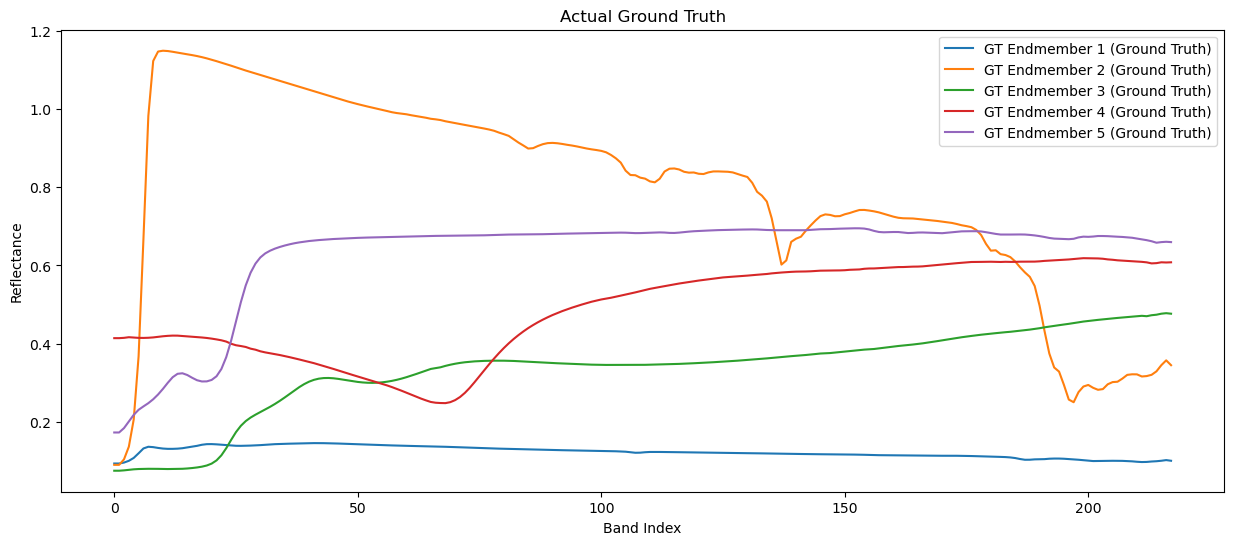

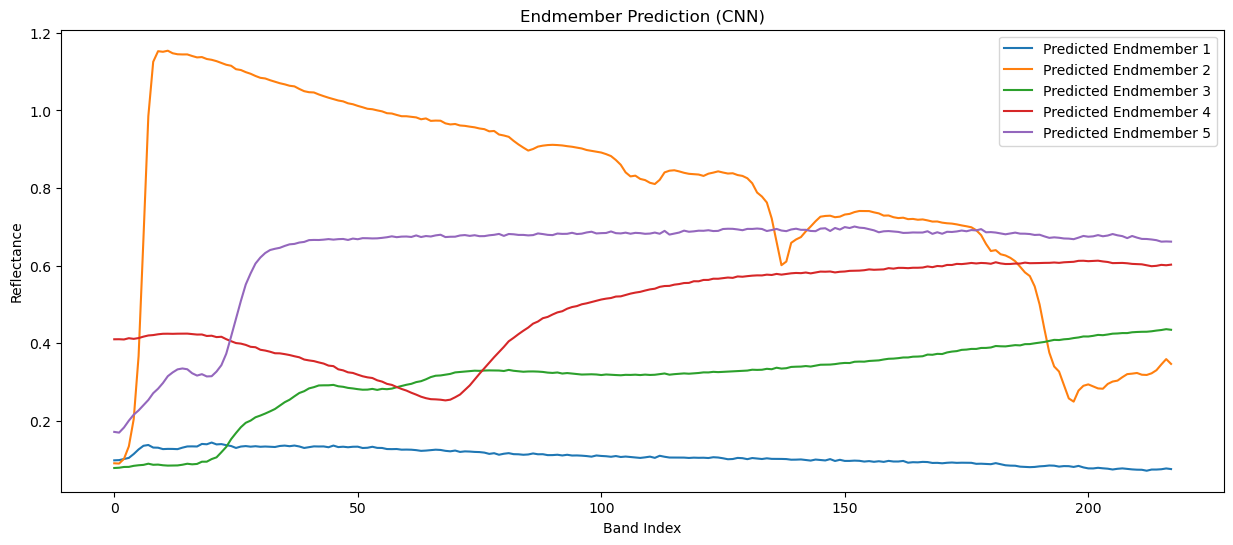

In [15]:
import matplotlib.pyplot as plt
# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(15, 6))
for i in range(endmembers_gt.shape[0]):
    plt.plot(endmembers_gt[ i,:], label=f'GT Endmember {i + 1} (Ground Truth)')
plt.title('Actual Ground Truth')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(15, 6))
for i in range(endmembers_gt.shape[0]):
    plt.plot(predictions[ i, :].numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')

plt.title('Endmember Prediction (CNN)')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

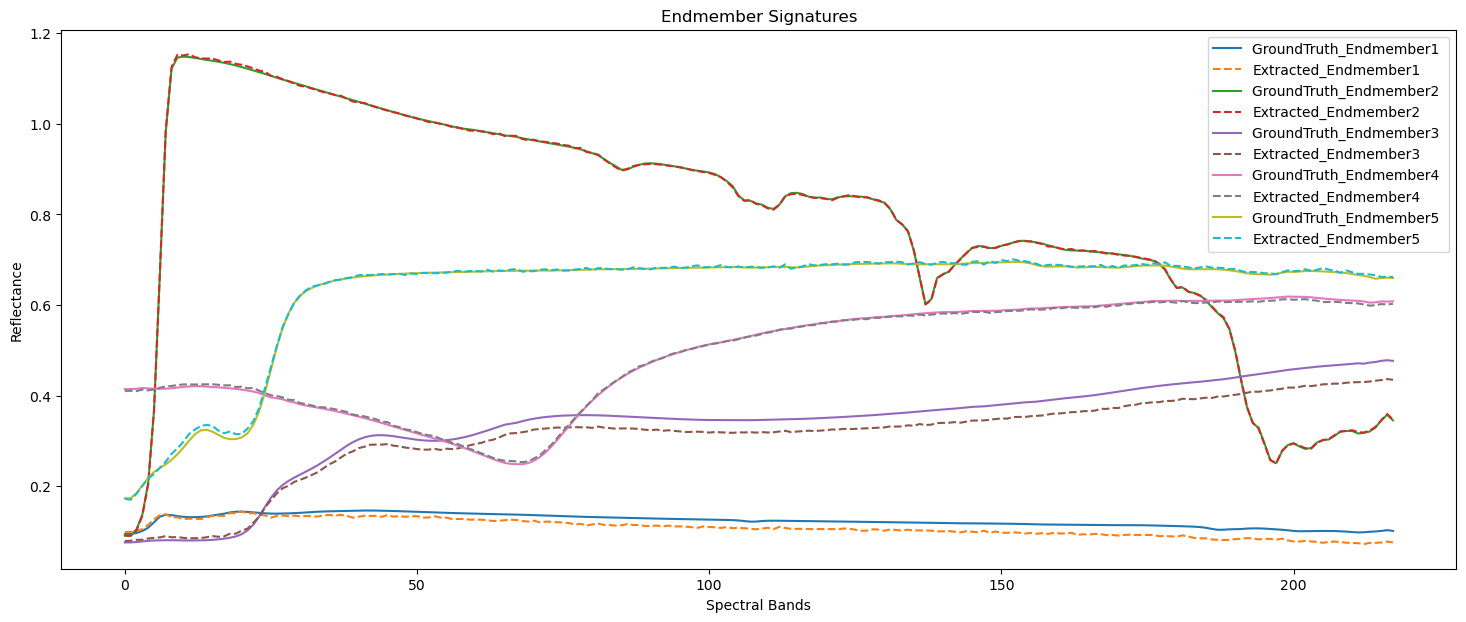

In [16]:
import matplotlib.pyplot as plt
# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(18,7))
for i in range(endmembers_gt.shape[0]):
    plt.plot(endmembers_gt[ i,:], label=f'GroundTruth_Endmember{i + 1} ')
    plt.plot(predictions[ i, :].numpy(), linestyle='dashed', label=f'Extracted_Endmember{i + 1}')
plt.title('Endmember Signatures')
plt.xlabel('Spectral Bands')
plt.ylabel('Reflectance')
plt.legend()
plt.show()